In [2]:
__author__ = 'Shi Fan'
import glob
import pandas as pd, numpy as np
import pylab as pl
import os
%pylab inline
from scipy import signal
import pickle as pkl

Populating the interactive namespace from numpy and matplotlib


In [3]:
int_times = [1, 3, 7, 20, 55, 125]

# setting values for image dimension early on
nrow = 240
ncol = 320
nband = 3

REREAD=False
#REREAD=True
#FBB adding env variable so it is easy to run on different machines
datapath=os.getenv('UIdata')
print (datapath)
if not datapath:
    datapath = '/scratch/share/dm3805'
    print (datapath)

if REREAD:
    
    close_photos = {}
    mid_photos = {}

    for i in int_times:
        close_path = datapath+'/SNRtest/*%dint*close*.raw' % i
        mid_path = datapath+'/SNRtest/*%dint*mid*.raw' % i
        
        close_photos[i] = glob.glob(close_path)
        mid_photos[i] = glob.glob(mid_path)
        
    #Converting series into Numpy arrays
    close_photo_arr = {}
    mid_photo_arr = {}

    for key, value in close_photos.iteritems():
        close_photo_arr[key] = np.array(value)[np.argsort(value)] 
        
    for key, value in mid_photos.iteritems():
        mid_photo_arr[key] = np.array(value)[np.argsort(value)]
        
    pl.figure()
    pl.imshow(np.fromfile(close_photo_arr[7][10], dtype=np.uint8).reshape(nrow, ncol, nband)[75:175,100:200]);

None
/scratch/share/dm3805


In [4]:
pickle_path = '/scratch/share/fbianco/ht_pickles'

if REREAD:
    close_photo_resized = {}
    mid_photo_resized = {}
    
    # initialization
    for key, value in close_photo_arr.iteritems():
        close_photo_resized[key] = np.zeros(len(value))
    for key, value in mid_photo_arr.iteritems():
        mid_photo_resized[key] = np.zeros(len(value))

    # close range
    for r in close_photo_resized:
        for i,f in enumerate(close_photo_arr[r]):
            close_photo_resized[r][i] = sum(np.fromfile(f,dtype=np.uint8).reshape(nrow,ncol,nband)[75:175,100:200]) 
    pkl.dump(close_photo_resized, open(pickle_path+'/SNRtest_close.pkl', 'wb'))
    
    # mid range
    for r in mid_photo_resized:
        for i,f in enumerate(mid_photo_arr[r]):
            mid_photo_resized[r][i] = sum(np.fromfile(f,dtype=np.uint8).reshape(nrow,ncol,nband)[75:175,100:200]) 
    pkl.dump(mid_photo_resized, open(pickle_path+'/SNRtest_mid.pkl', 'wb'))

else:
    #FBB this is when we do not want to reread the images but just use the time series
    pklfiles = glob.glob(datapath+'/ht_pickles/SNRtest*.pkl')
    close_photo_resized = pkl.load(open(pickle_path+'/SNRtest_close.pkl', 'rb'))
    mid_photo_resized = pkl.load(open(pickle_path+'/SNRtest_mid.pkl', 'rb'))

In [5]:
#function definitions
#we like them altogether so we can easily find a function definition when we need to

def mynorm(flux):
    flux -= flux.mean()
    return 2*(flux-flux.min())/(flux.max()-flux.min())
        
def plot_flux_by_runtime(flux, c_freq, runtime, close):
    for key, value in flux.iteritems():
        pl.figure(figsize=(20,5))
        if close:
            color = 'dodgerblue'
            pl.title('Close-up Flux: Shutter 119.75Hz; Camera '+str(c_freq)+'Hz; Integration '+str(key)+'ms', fontsize=20)
        else:
            color = 'steelblue'
            pl.title('Mid-range Flux: Shutter 119.75Hz; Camera '+str(c_freq)+'Hz; Integration '+str(key)+'ms', fontsize=20)
        try:
            pl.plot(runtime[c_freq], flux[key], '-', color=color, linewidth=0.75)
            pl.plot(runtime[c_freq], flux[key], 'o', color=color)
        except:
            print ('Camera frequency has to be 4')
            break
        pl.xlim(0,125)
        
        pl.xlabel("Seconds", fontsize=15)
        pl.ylabel("Almost normalized flux", fontsize=15)
        pl.ylim(-.1,2.1)
        pl.show() 

def folding(flux, runtime, freq):
    runtime_mod = np.mod( runtime, 2.0/freq)
    return flux, runtime_mod # return time in microseconds

## Setting up data

In [6]:
#Creating dictionaries for flux
#Normalizing flux by (flux-mean)/std

close_flux = {}
mid_flux = {}

for key, value in close_photo_resized.iteritems():
    close_flux[key] = mynorm(value)
    
for key, value in mid_photo_resized.iteritems():
    mid_flux[key] = mynorm(value)
    
runtime4 = np.linspace(0, len(mid_photo_resized[1])/4.0, len(mid_photo_resized[1]), endpoint=True)

## Flux vs time

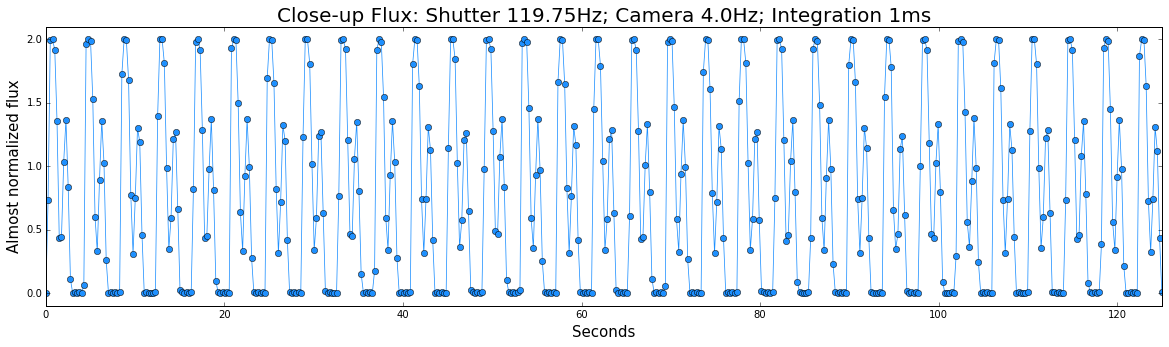

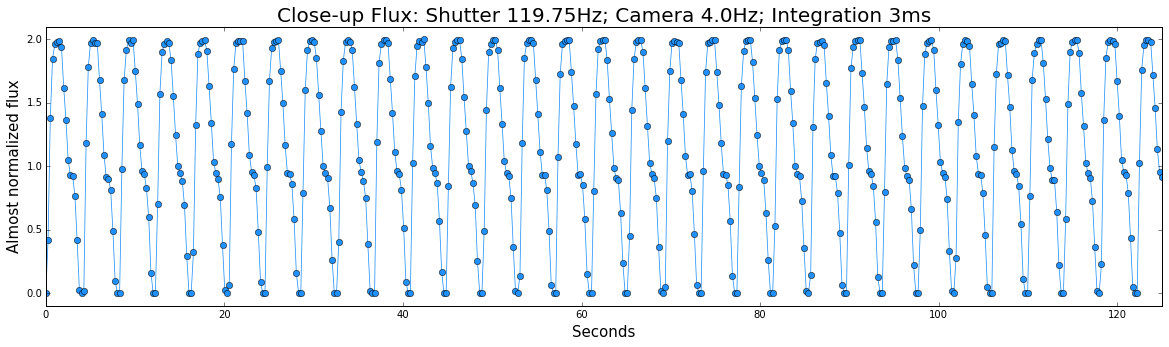

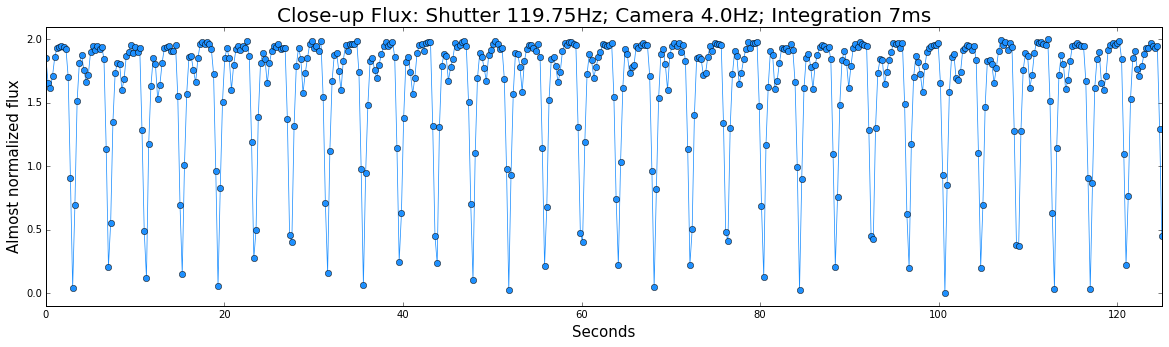

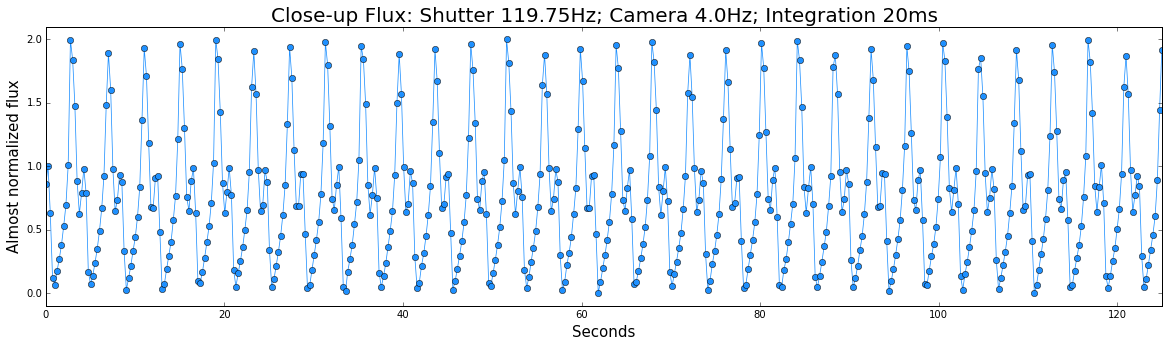

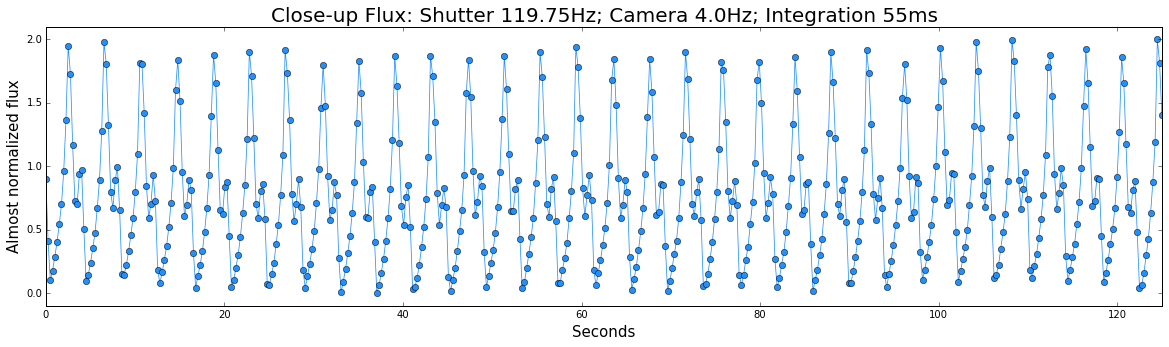

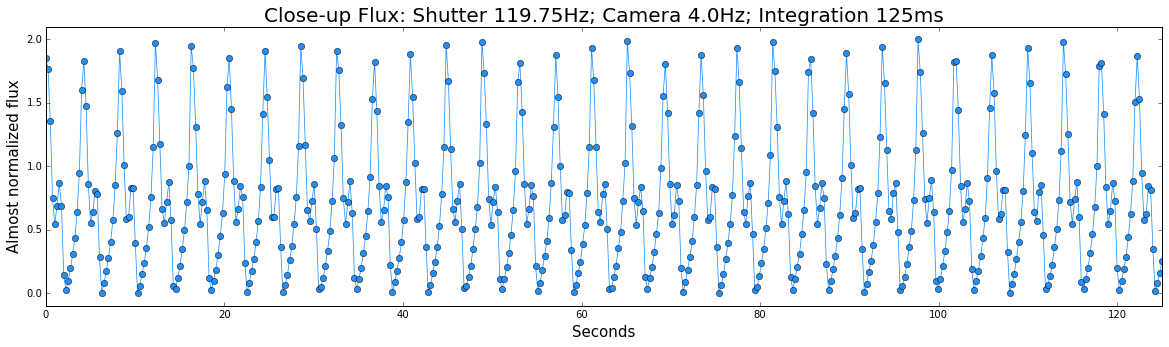

In [7]:
plot_flux_by_runtime(close_flux, 4.0, {4.0:runtime4}, True)

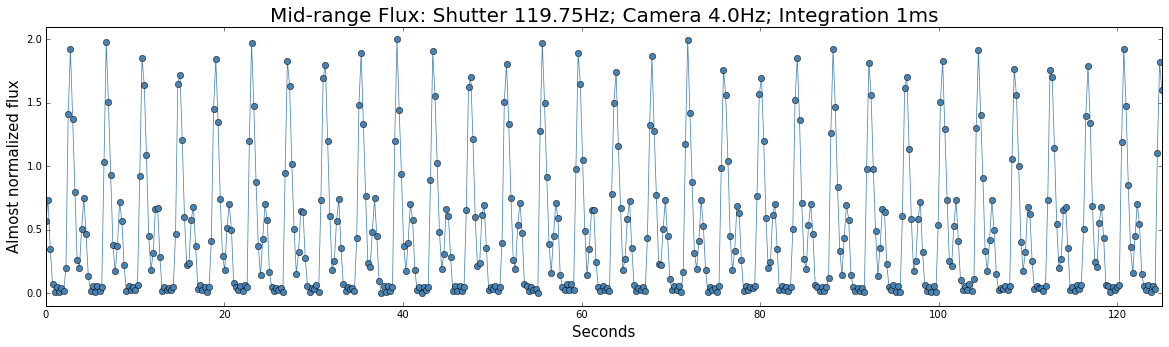

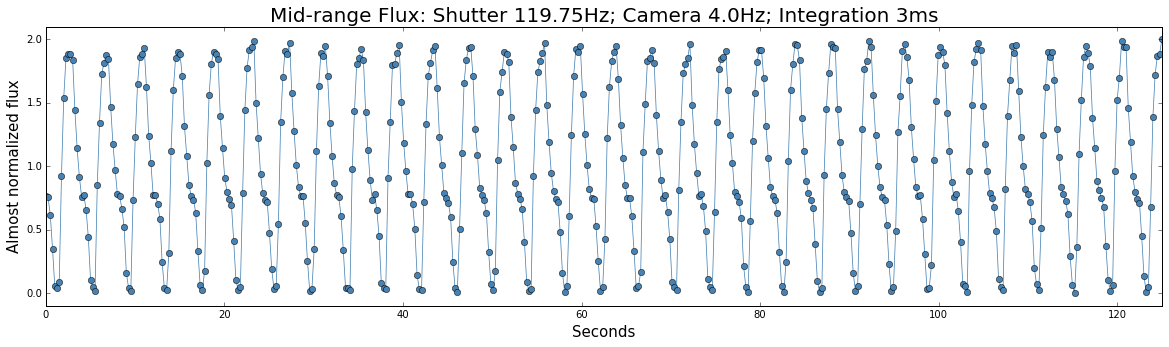

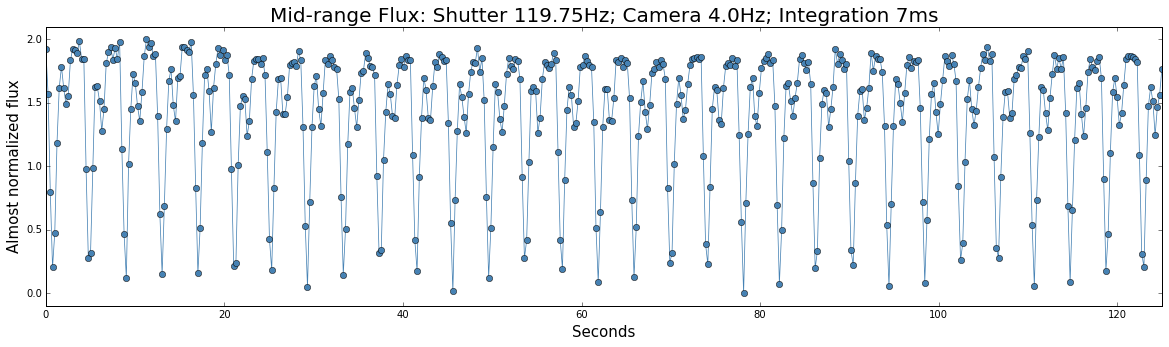

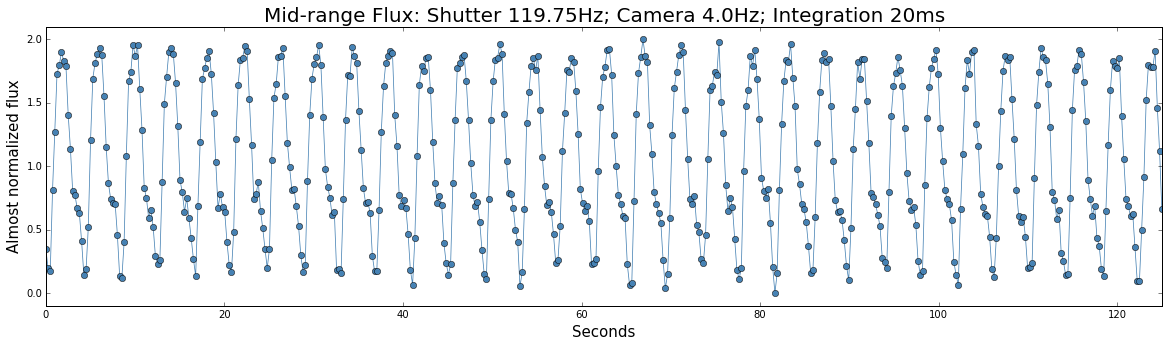

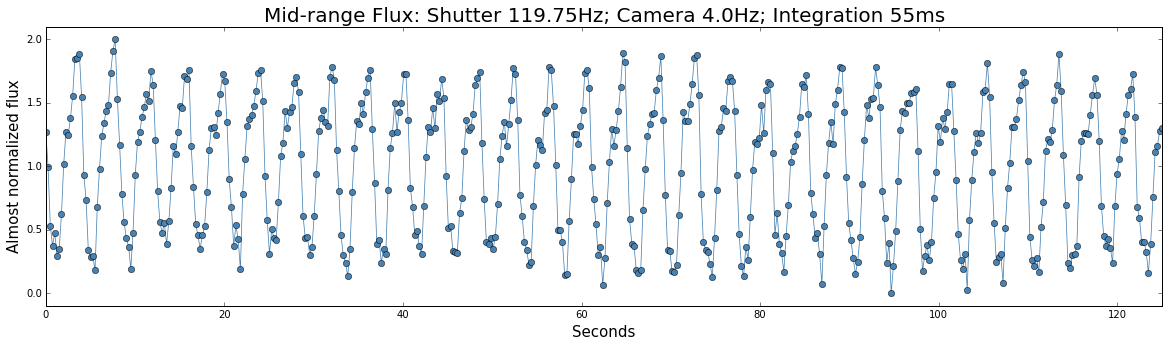

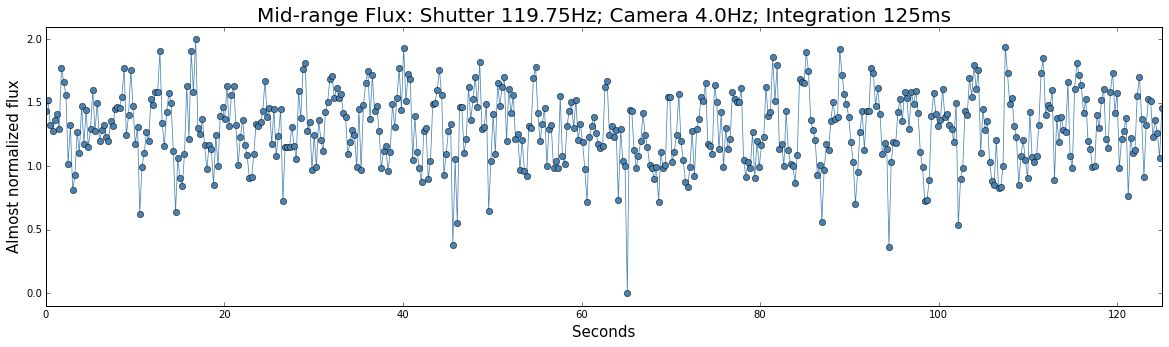

In [10]:
plot_flux_by_runtime(mid_flux, 4.0, {4.0:runtime4}, False)

## Folded flux (2 shutter cycles)

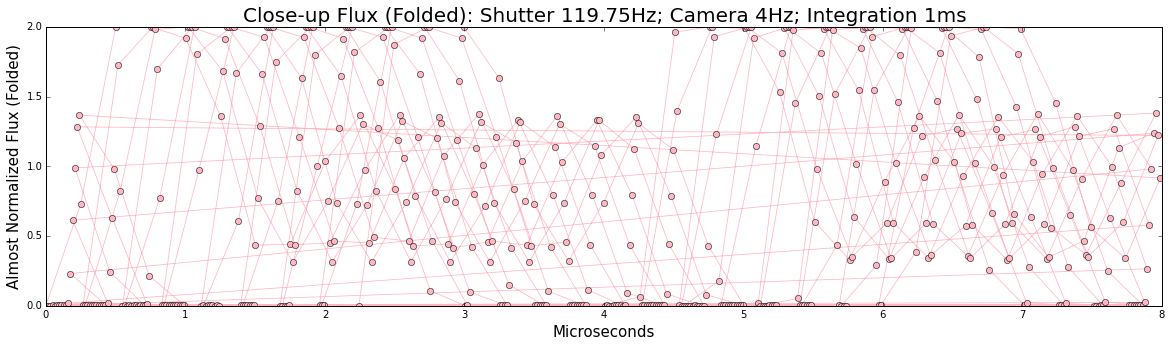

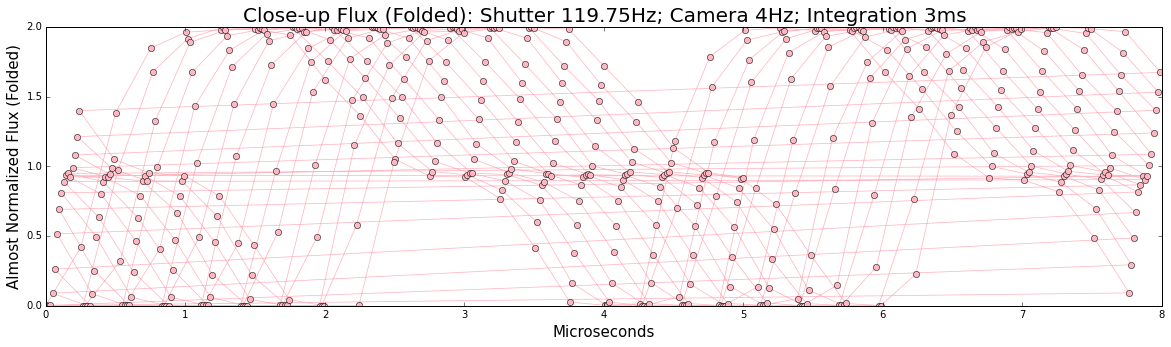

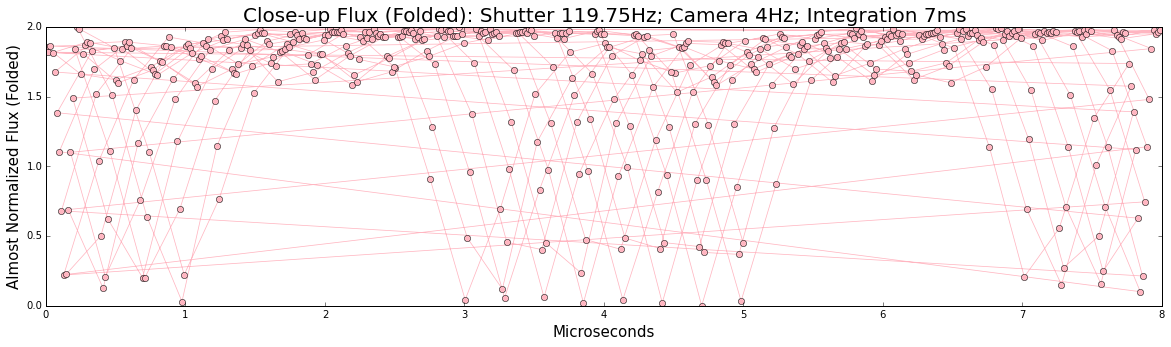

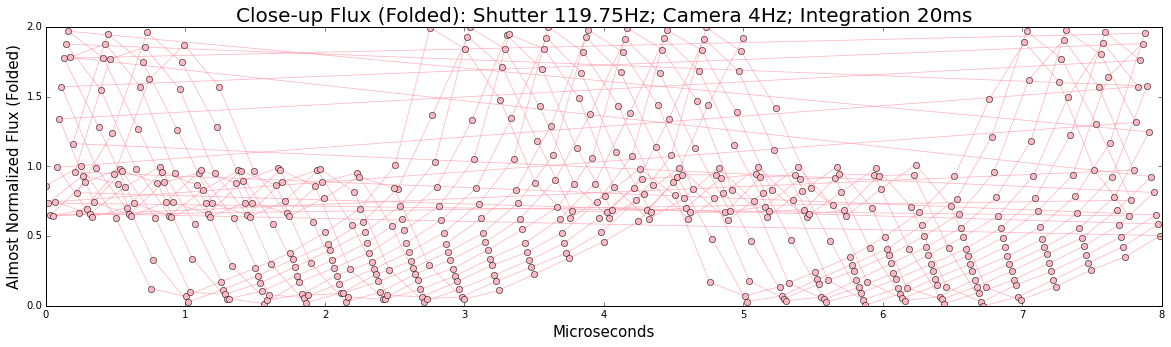

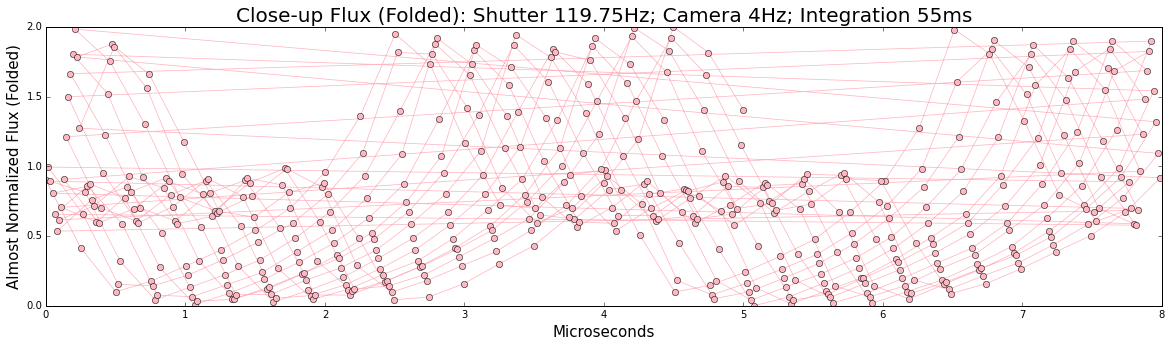

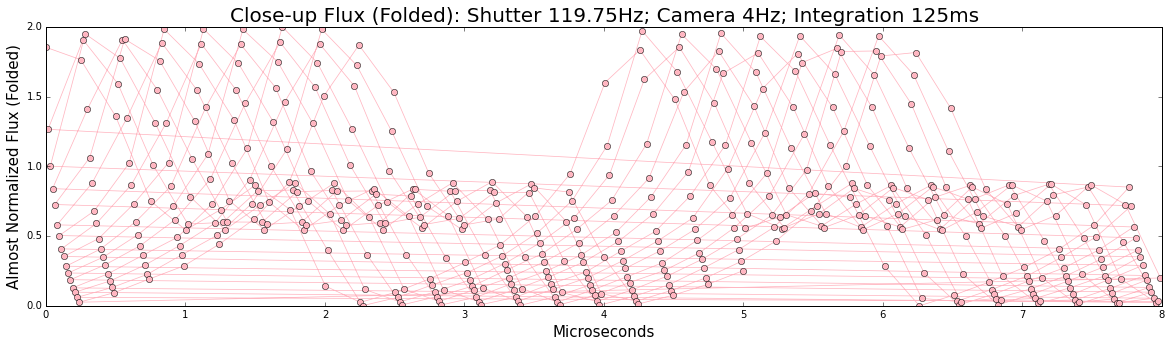

In [11]:
folded_close = {}
expected_freq = 0.25
for key, value in close_flux.iteritems():
    folded_close[key] = {}
    folded_close[key]['flux'], folded_close[key]['time'] = folding(value, runtime4, expected_freq)
    
    pl.figure(figsize=(20,5))
    pl.plot(folded_close[key]['time'], folded_close[key]['flux'], '-', color='lightpink', linewidth=0.75)
    pl.plot(folded_close[key]['time'], folded_close[key]['flux'], 'o', color='lightpink')
    pl.xlabel("Microseconds", fontsize=15)
    pl.ylabel("Almost Normalized Flux (Folded)", fontsize=15)
    pl.title('Close-up Flux (Folded): Shutter 119.75Hz; Camera 4Hz; Integration '+str(key)+'ms', fontsize=20)
    pl.xlim(0,2/expected_freq)
    pl.show()

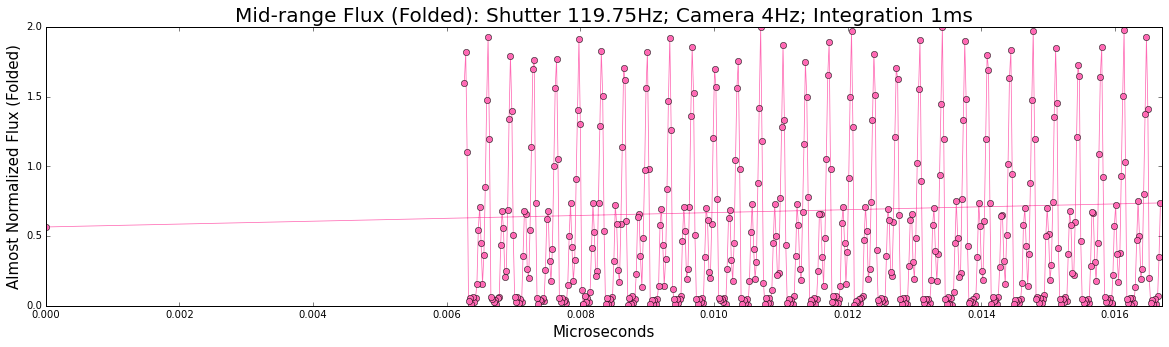

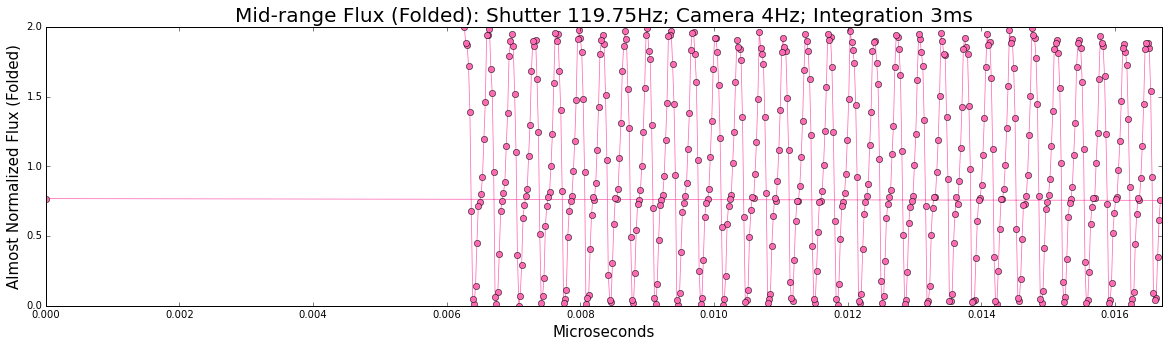

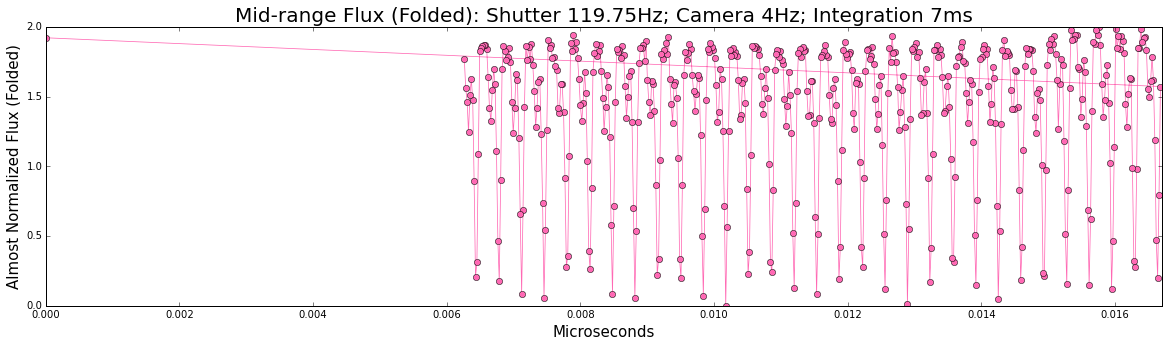

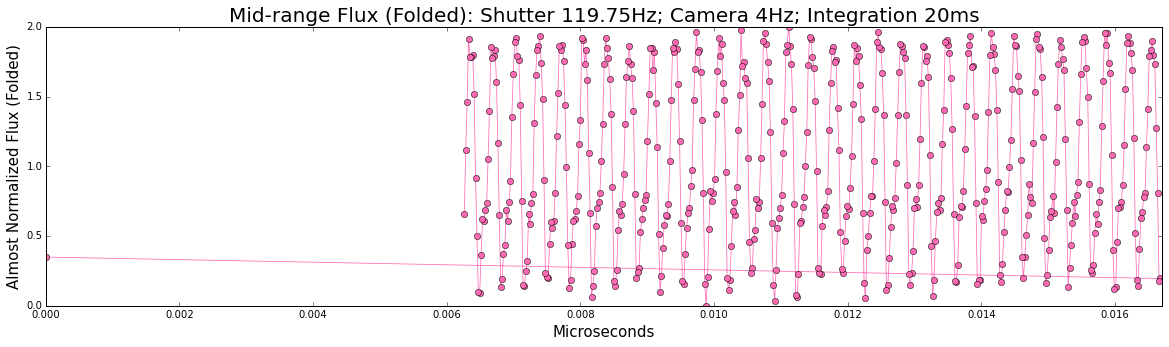

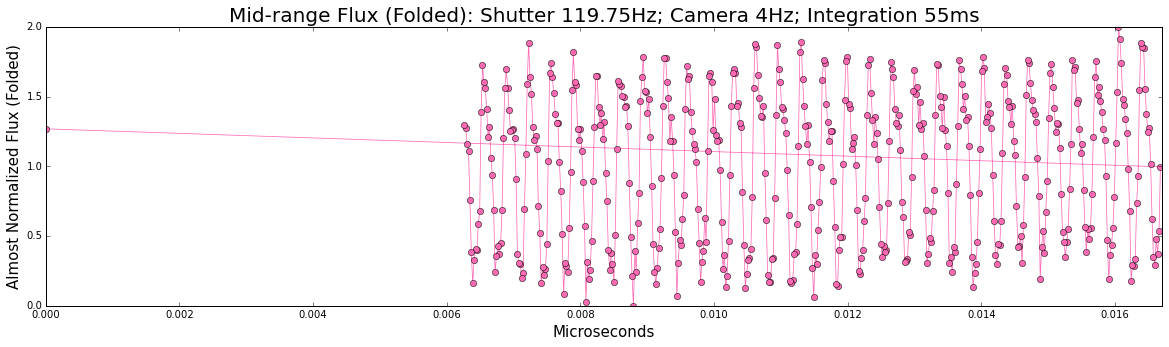

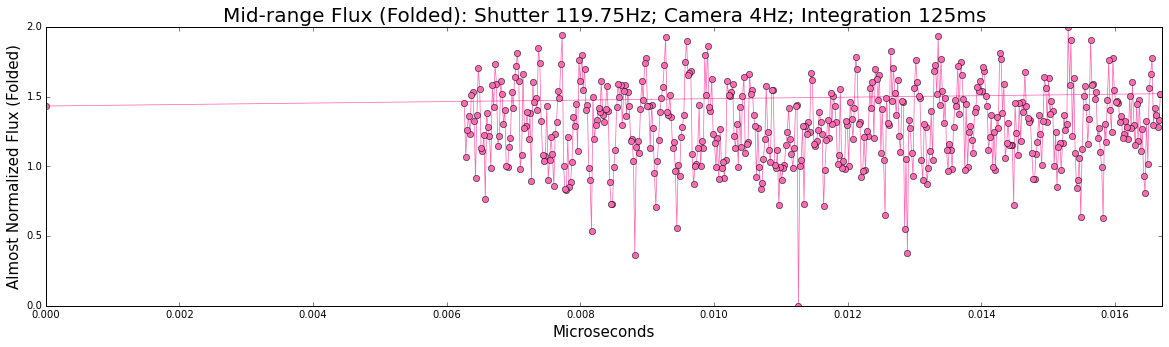

In [9]:
folded_mid = {}

for key, value in mid_flux.iteritems():
    folded_mid[key] = {}
    folded_mid[key]['flux'], folded_mid[key]['time'] = folding(value, runtime4, 119.75)
    
    pl.figure(figsize=(20,5))
    pl.plot(folded_mid[key]['time'], folded_mid[key]['flux'], '-', color='hotpink', linewidth=0.75)
    pl.plot(folded_mid[key]['time'], folded_mid[key]['flux'], 'o', color='hotpink')
    pl.xlabel("Microseconds", fontsize=15)
    pl.ylabel("Almost Normalized Flux (Folded)", fontsize=15)
    pl.title('Mid-range Flux (Folded): Shutter 119.75Hz; Camera 4Hz; Integration '+str(key)+'ms', fontsize=20)
    pl.xlim(0,2/119.75)
    pl.show()